# Mapas Covid

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import os
import geopandas as gpd
import geoplot
import mapclassify
import zipfile
from tensorflow.keras.utils import get_file
style.use('default')

In [2]:
plt.rcParams['backend'] = 'SVG'

## Carregando dados
Utilizando planilha do [Portal sobre Covid19 do Ministério da Saúde]('https://covid.saude.gov.br/')

In [3]:
fZipName = 'HIST_PAINEL_COVIDBR_02nov2020'
zf = zipfile.ZipFile('../data/' + fZipName + '.zip') 
df = pd.read_csv(zf.open( fZipName + '.csv'), sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242668 entries, 0 to 1242667
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   regiao                  1242668 non-null  object 
 1   estado                  1242415 non-null  object 
 2   municipio               1230970 non-null  object 
 3   coduf                   1242668 non-null  int64  
 4   codmun                  1235611 non-null  float64
 5   codRegiaoSaude          1230970 non-null  float64
 6   nomeRegiaoSaude         1230970 non-null  object 
 7   data                    1242668 non-null  object 
 8   semanaEpi               1242668 non-null  int64  
 9   populacaoTCU2019        1238027 non-null  float64
 10  casosAcumulado          1242668 non-null  int64  
 11  casosNovos              1242668 non-null  int64  
 12  obitosAcumulado         1242668 non-null  int64  
 13  obitosNovos             1242668 non-null  int64  
 14  Re

### Dias de semana como varíável categórica 

In [4]:
cat_dia_semana = pd.CategoricalDtype(categories=['dom', 'seg', 'ter', 'qua', 'qui', 'sex', 'sab'], ordered=True)
df['data'] = pd.to_datetime(df['data'],format="%Y-%m-%d")
df['dia_semana'] = df['data'].dt.dayofweek
df['dia_semana_nm'] = df['dia_semana'].replace({0:'seg', 1: 'ter', 2:'qua', 3:'qui', 4:'sex', 5:'sab', 6:'dom'}).astype(cat_dia_semana)

## Entre com a silga do estado e o nome da cidade

In [5]:
uf = 'DF'
Muni = 'Brasília'

### Função de tratamento dos dados
* recebe o banco de dados, a sigla do estado e o nome da cidade
* retorna:
    1. DataFrame do estado
    1. DataFrame do estado agregado por semana epidemiológica
    1. DataFrame da cidade
    1. DataFrame da cidade agregado por semana epidemiológica


In [6]:
def preproc_filter_df(df,estado, cidade):
    fltr = df['estado'].str.lower() == estado.lower()
    df_UF = df.loc[fltr, :]
    df_UF_sem = df_UF.groupby('semanaEpi')
    df_UF_sem = df_UF_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    fltr = df_UF['municipio'].str.lower() == cidade.lower()
    df_muni = df_UF.loc[fltr, :]
    df_muni_sem = df_muni.groupby('semanaEpi')
    df_muni_sem = df_muni_sem.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'}).reset_index()
    return df_UF, df_UF_sem, df_muni, df_muni_sem

In [7]:
df_est, df_est_sem, df_cidade, df_cidade_sem = preproc_filter_df(df, uf, Muni)

In [8]:

def casos_acumulados(df_muni, muni, pathfigs = './figs/'):
    df_muni.sort_values('data', inplace = True)
    df_muni['ca_log'] = df_muni['casosAcumulado'].apply(lambda x: np.log10(x))
    dia_0 = df_muni['data'].min()
    df_muni['dia_num'] = (df_muni['data'] - dia_0).apply(lambda x: x.days)
### figura 01 -casos acumulados por dia
    plt.figure(1, figsize=(10,10))
    plt.title('{}: \n Casos Acumulados por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'casosAcumulado', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
##### figura 01 -casos acumulados por dia(log)
    plt.figure(2, figsize=(10,10))
    plt.title('{}: \n Casos por Dia'.format(muni).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Casos Acumulados por Dia(log)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.plot('data', 'ca_log', data=df_muni, color= 'royalblue', linewidth=7)
    plt.savefig( pathfigs + muni + '_Casos_Acumulados_log10_' + str(df_muni['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(2)
    print ('dia zero', dia_0)
    print('Casos Novos\n',df_muni.loc[:,['casosNovos', 'data']].tail(14))
    print('Casos Totais\n', df_muni['casosAcumulado'].max())
    

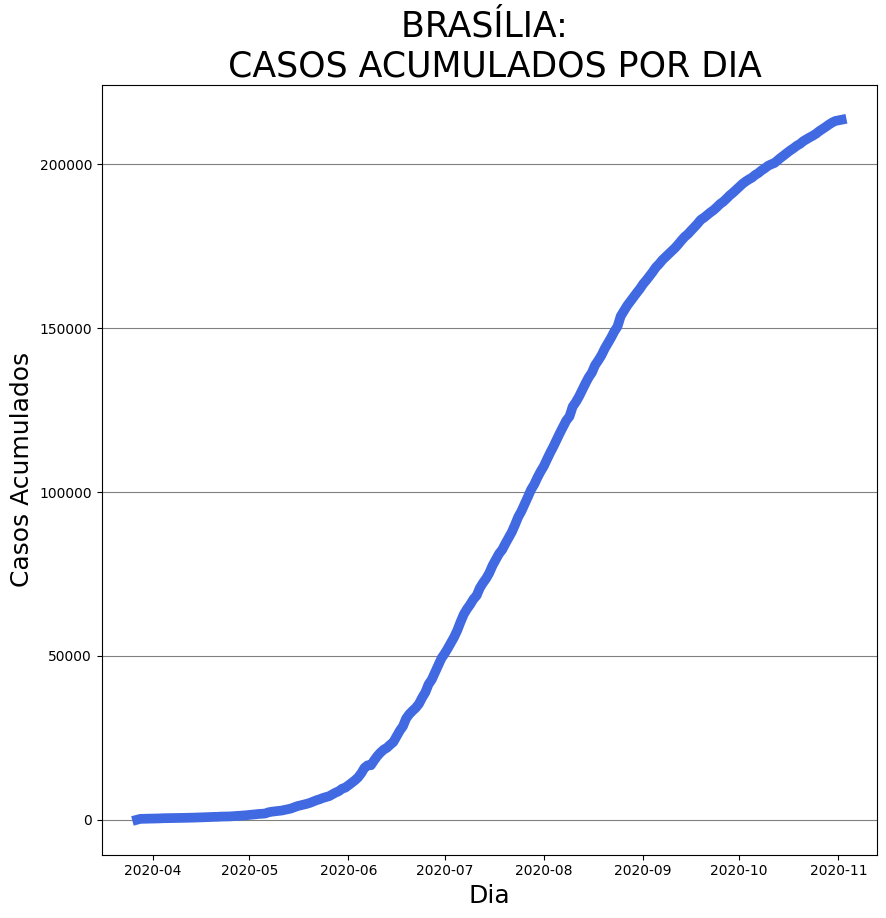

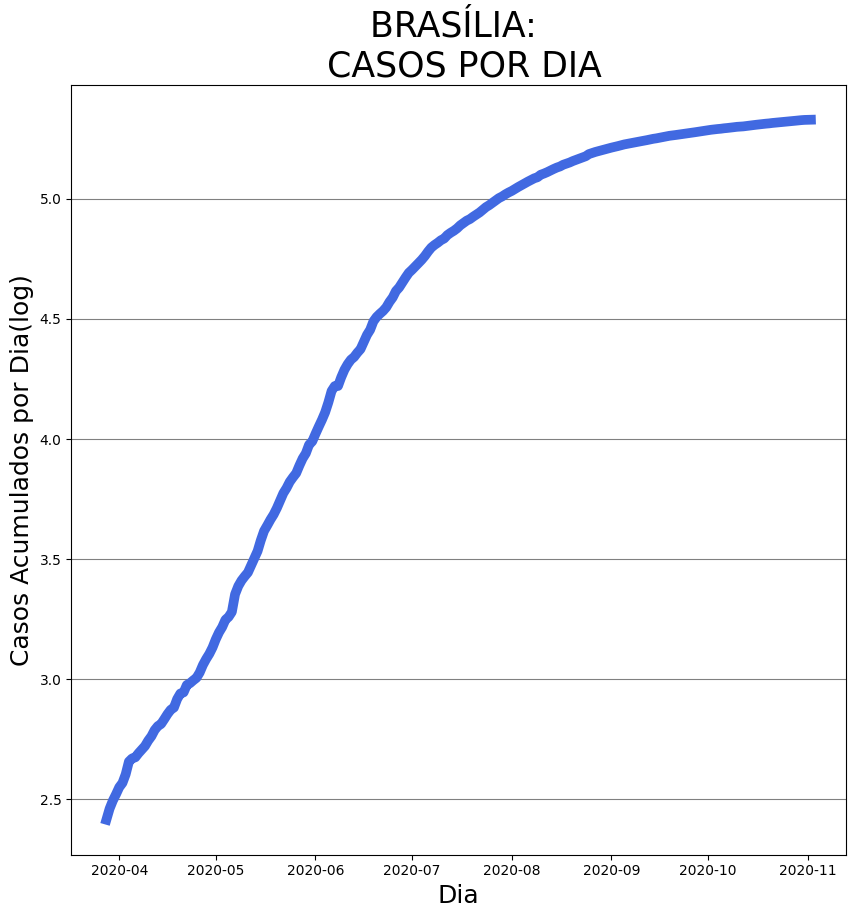

dia zero 2020-03-27 00:00:00
Casos Novos
          casosNovos       data
1242654         556 2020-10-20
1242655         815 2020-10-21
1242656         590 2020-10-22
1242657         565 2020-10-23
1242658         526 2020-10-24
1242659         608 2020-10-25
1242660         776 2020-10-26
1242661         629 2020-10-27
1242662         668 2020-10-28
1242663         698 2020-10-29
1242664         622 2020-10-30
1242665         483 2020-10-31
1242666         211 2020-11-01
1242667         180 2020-11-02
Casos Totais
 213636


In [9]:
casos_acumulados(df_cidade, Muni)

### Função Grafico de casos por dia

In [10]:
def casos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    print('Casos Totais\n', df1['casosAcumulado'].max())

    fig = plt.figure(1, figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='casosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    
    plt.title('{}: \n Casos por Semana Epidemiológica por Dia'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=20)
    plt.ylabel('Número de Casos', fontsize=20)
    plt.grid(axis='y', color='grey')
    plt.rcParams['legend.title_fontsize'] = 18

    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_casos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)

Casos Totais
 213636


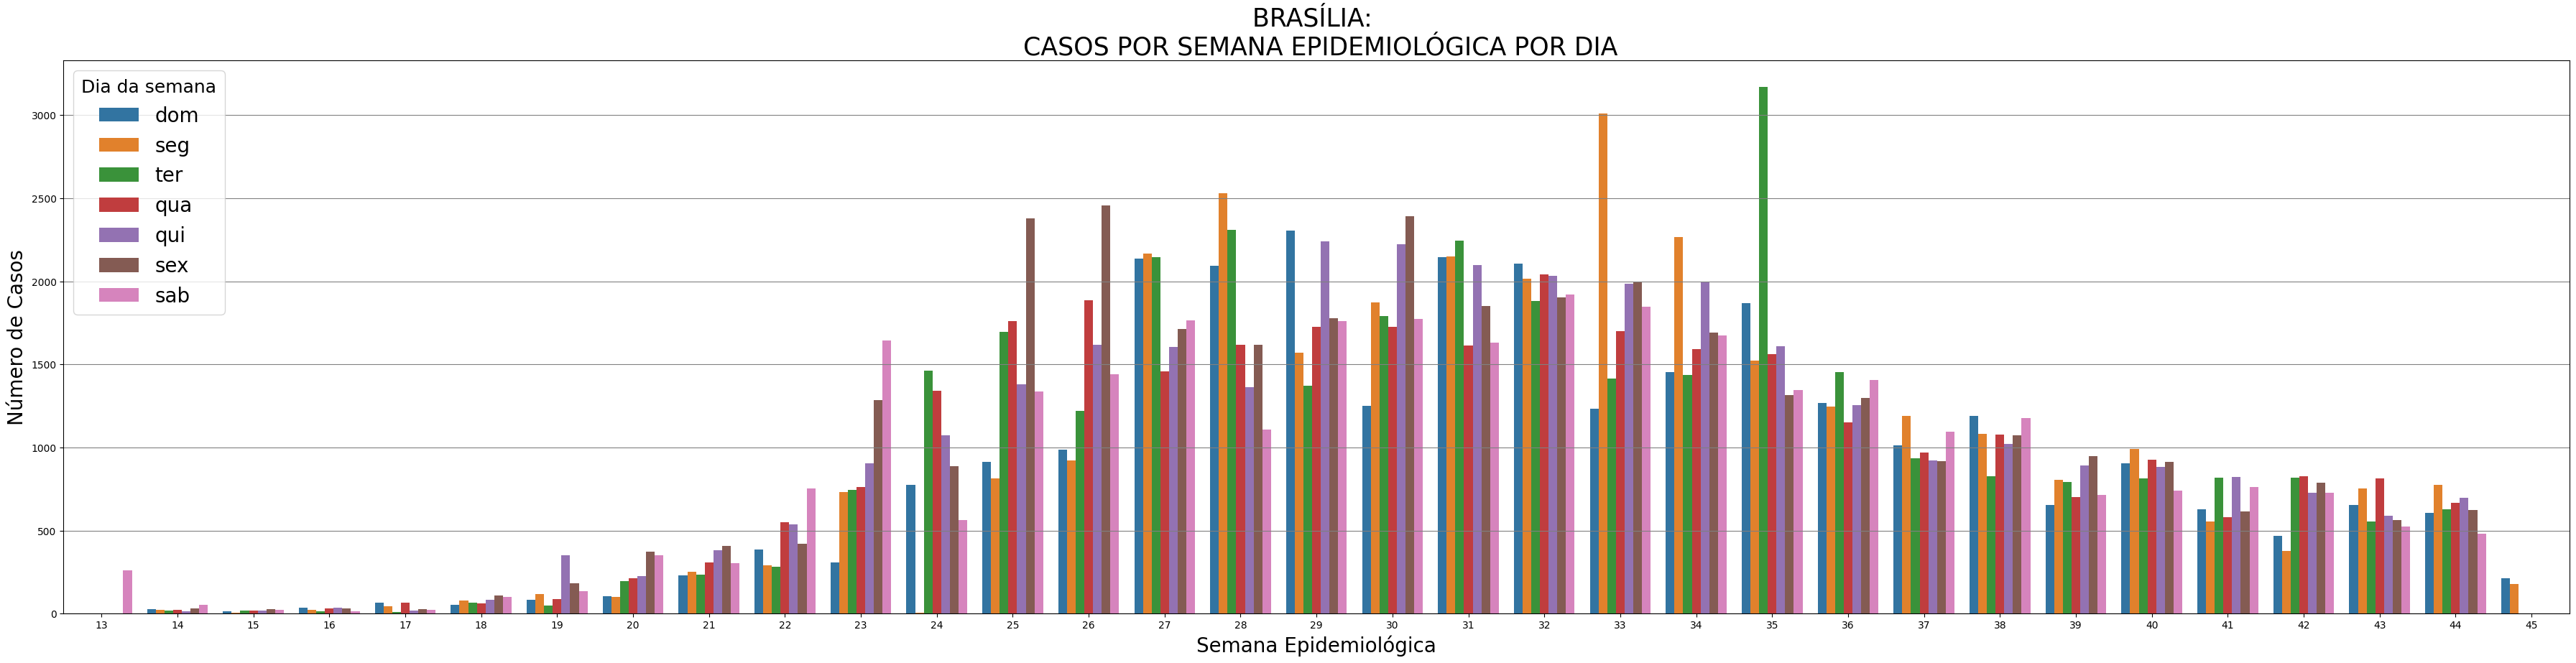

In [11]:
casos_dia_local(df_cidade, Muni)

### Casos por dia (média móvel de 5 dias centralizada)

In [12]:
def casos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ###- tratando números negativos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])

    df1['media_movel_casos'] =df1.rolling(7, center=False)['casosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Dia (média móvel de 7 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Casos (média móvel de 7 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_casos', data=df1, color= 'teal', width=.8)
    plt.savefig( pathfigs + local + '_dia_casos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_casos', 'data']].head(14))
    print(df1.loc[:,['media_movel_casos', 'data']].tail(14))

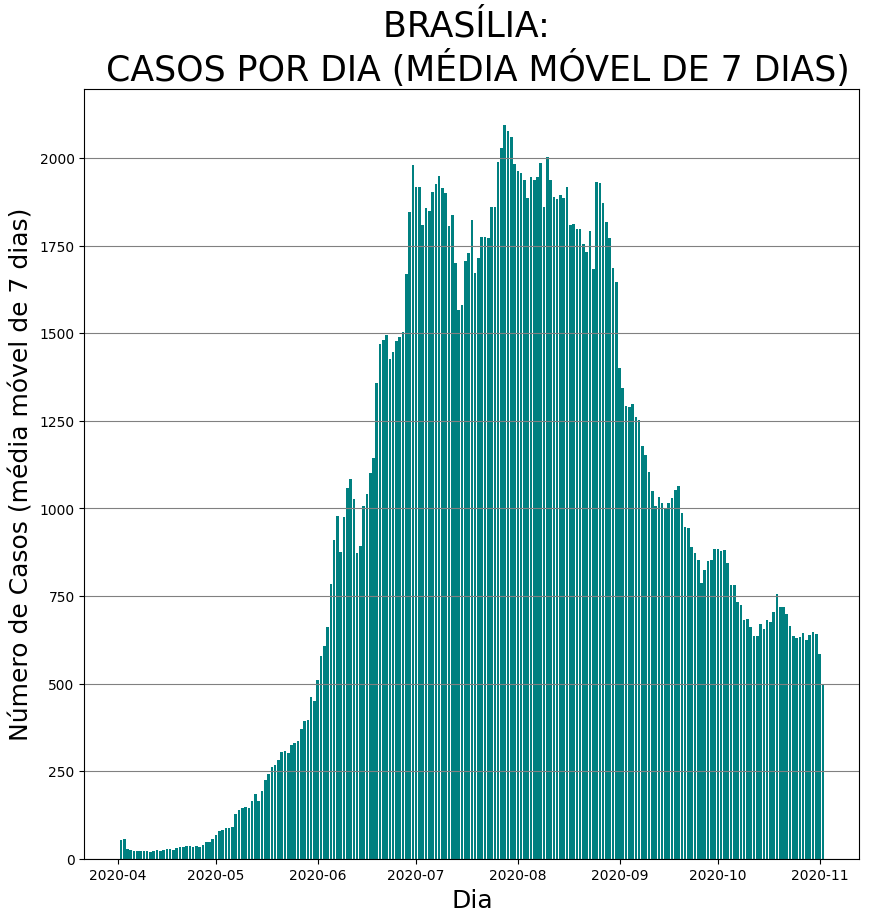

Média móvel por dia
          media_movel_casos       data
1242447                NaN 2020-03-27
1242448                NaN 2020-03-28
1242449                NaN 2020-03-29
1242450                NaN 2020-03-30
1242451                NaN 2020-03-31
1242452                NaN 2020-04-01
1242453          52.857143 2020-04-02
1242454          57.428571 2020-04-03
1242455          27.714286 2020-04-04
1242456          25.571429 2020-04-05
1242457          23.000000 2020-04-06
1242458          22.857143 2020-04-07
1242459          22.000000 2020-04-08
1242460          22.428571 2020-04-09
         media_movel_casos       data
1242654         719.285714 2020-10-20
1242655         717.428571 2020-10-21
1242656         697.714286 2020-10-22
1242657         665.571429 2020-10-23
1242658         636.714286 2020-10-24
1242659         630.285714 2020-10-25
1242660         633.714286 2020-10-26
1242661         644.142857 2020-10-27
1242662         623.142857 2020-10-28
1242663         638.571429 20

In [13]:
casos_dia_media_movel(df_cidade, Muni)

In [14]:
def obitos_dia_local(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)

    ### valores negativos de novos obitos
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    
    print('Óbitos por dia\n',df1.loc[:,['obitosNovos', 'data']].tail(14))
    print('Óbitos Totais\n', df1['obitosAcumulado'].max())

    fig =  plt.figure(1,figsize=(df1['semanaEpi'].max(),10))
    ax = sns.barplot(x='semanaEpi', y='obitosNovos', hue="dia_semana_nm", data=df1, dodge= True)
    plt.title('{}: \n Óbitos por Semana Epidemiológica por dia da semana'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.legend(title='Dia da semana', loc='upper left', prop={'size': 20})
    plt.savefig( pathfigs + local + '_dia_da_semana_obitos_' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show(1)
    


Óbitos por dia
          obitosNovos       data
1242654           14 2020-10-20
1242655           12 2020-10-21
1242656           13 2020-10-22
1242657           13 2020-10-23
1242658           10 2020-10-24
1242659           10 2020-10-25
1242660            8 2020-10-26
1242661           12 2020-10-27
1242662            8 2020-10-28
1242663            9 2020-10-29
1242664            6 2020-10-30
1242665            7 2020-10-31
1242666            5 2020-11-01
1242667            7 2020-11-02
Óbitos Totais
 3695


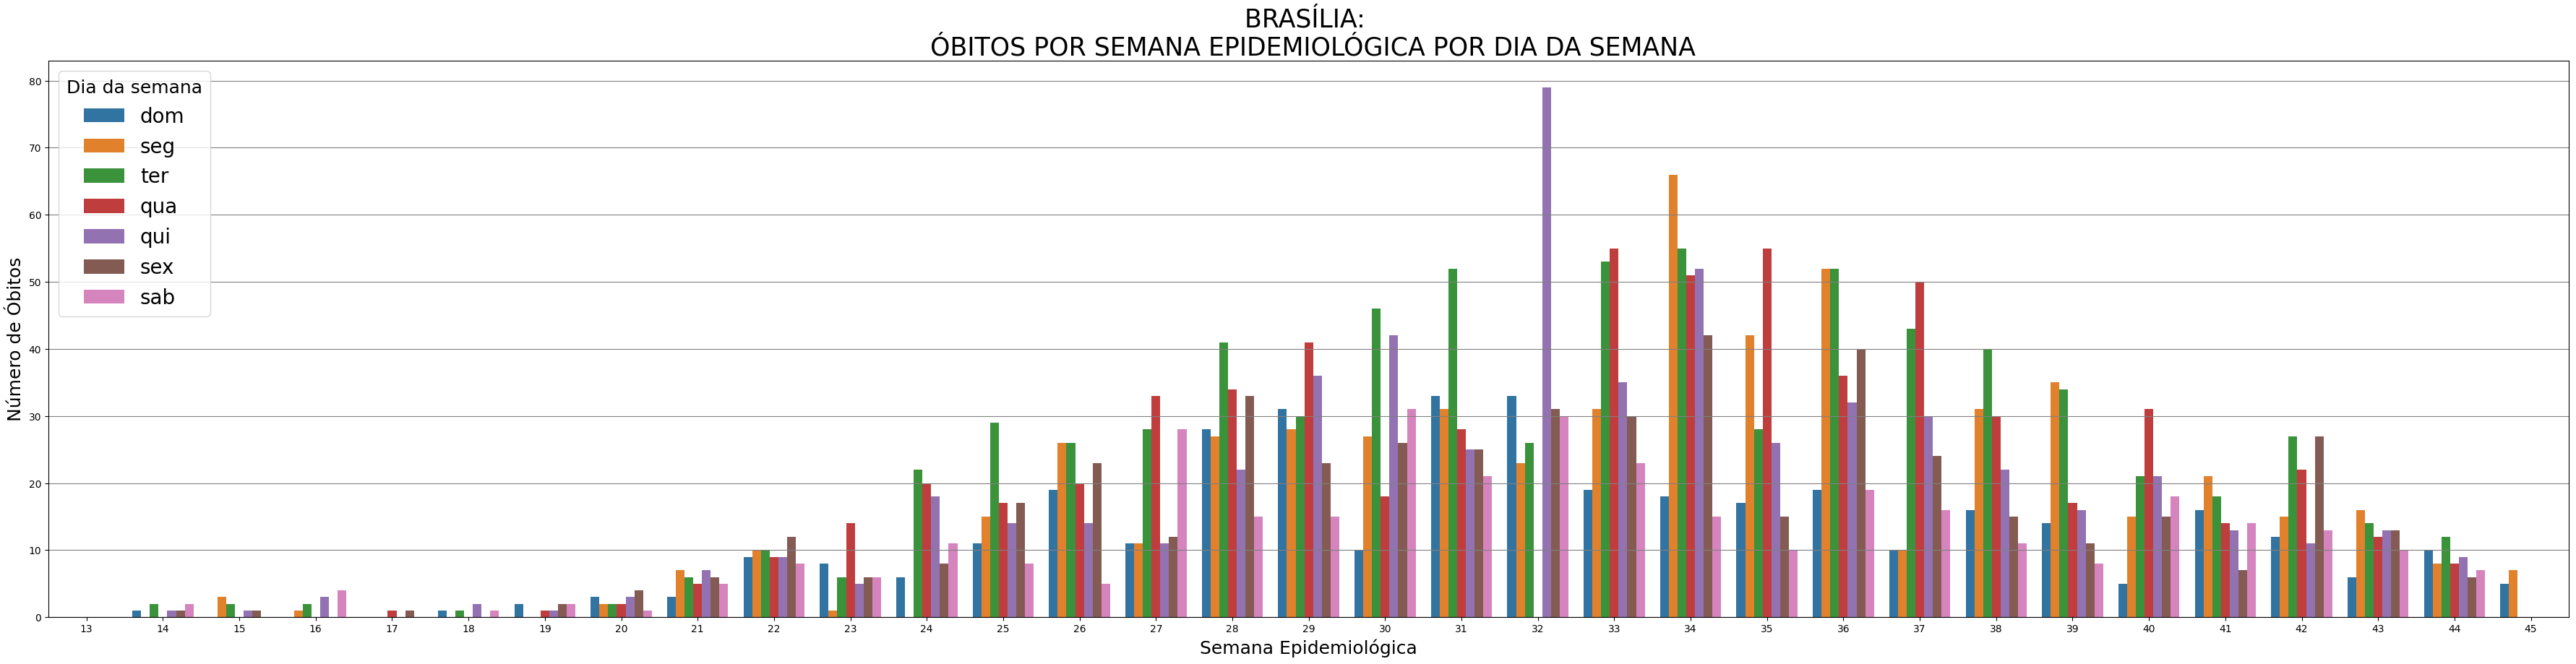

In [15]:
obitos_dia_local(df_cidade, Muni)

### Obitos por dia (média movel de 5 dias centralizada)

In [16]:
def obitos_dia_media_movel(df1, local, pathfigs = './figs/'):
    df1.sort_values('data', inplace = True)
    df1['obitosNovos'] = np.absolute(df1['obitosNovos'])
    df1['media_movel_obitos'] =df1.rolling(7, center=False)['obitosNovos'].mean()
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Óbitos por Dia (média móvel de 7 dias)'.format(local).upper(), fontsize=25)
    plt.xlabel('Dia', fontsize=18)
    plt.ylabel('Número de Óbitos (média móvel de 7 dias)', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('data', 'media_movel_obitos', data=df1, color= 'saddlebrown', width=.8)
    plt.savefig( pathfigs + local + '_dia_obitos_Media_Movel' + str(df1['data'].max()).replace(":", "_") + '.png', format ='png')
    plt.show()
    print('Média móvel por dia\n', df1.loc[:,['media_movel_obitos', 'data']].head(14))
    print(df1.loc[:,['media_movel_obitos', 'data']].tail(14))

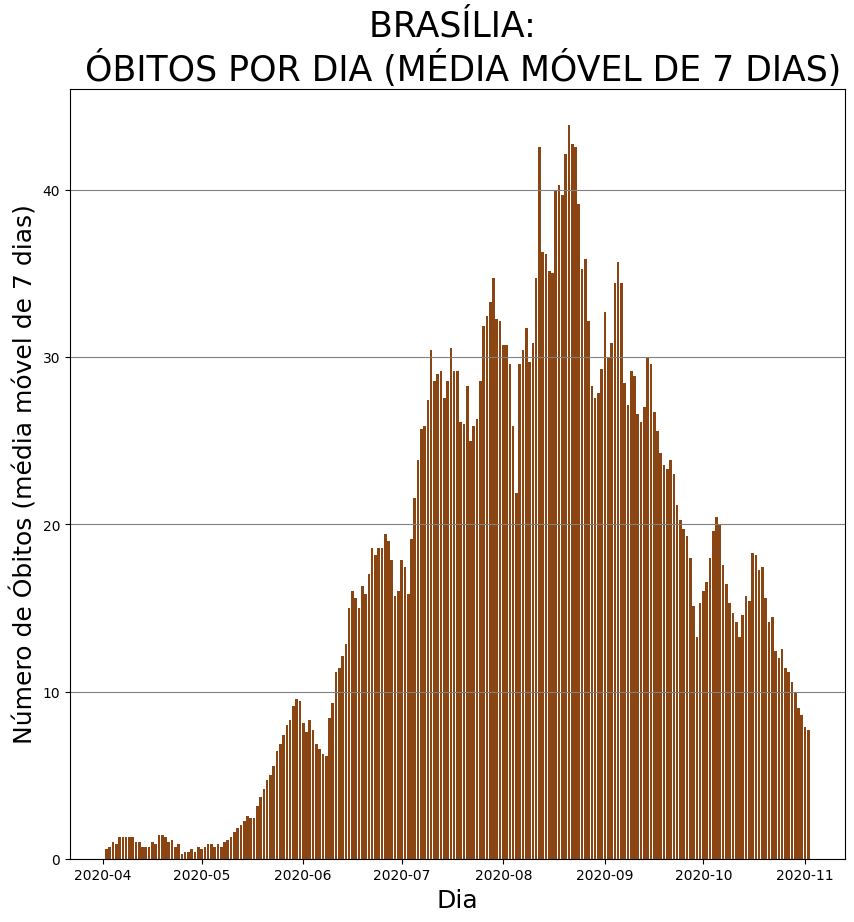

Média móvel por dia
          media_movel_obitos       data
1242447                 NaN 2020-03-27
1242448                 NaN 2020-03-28
1242449                 NaN 2020-03-29
1242450                 NaN 2020-03-30
1242451                 NaN 2020-03-31
1242452                 NaN 2020-04-01
1242453            0.571429 2020-04-02
1242454            0.714286 2020-04-03
1242455            1.000000 2020-04-04
1242456            0.857143 2020-04-05
1242457            1.285714 2020-04-06
1242458            1.285714 2020-04-07
1242459            1.285714 2020-04-08
1242460            1.285714 2020-04-09
         media_movel_obitos       data
1242654           15.571429 2020-10-20
1242655           14.142857 2020-10-21
1242656           14.428571 2020-10-22
1242657           12.428571 2020-10-23
1242658           12.000000 2020-10-24
1242659           12.571429 2020-10-25
1242660           11.428571 2020-10-26
1242661           11.142857 2020-10-27
1242662           10.571429 2020-10-28
1242

In [17]:
obitos_dia_media_movel(df_cidade, Muni)

### Função gráfico de casos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [18]:
def casos_semana_local(df, local, pathfigs = './figs/'):    
    plt.figure(figsize=(10,10))
    plt.title('{}: \n Casos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Casos', fontsize=18)
    plt.grid(axis='y', color='grey')
    plt.bar('semanaEpi', 'casosNovos', data=df, color= 'seagreen', width=.5)
    plt.savefig( pathfigs + local + '_semana_casos_' + str(df['semanaEpi'].max()) + '.png', format ='png')
    plt.show()
    print('Casos por semana epidemiológica\n',df.loc[:,['semanaEpi','casosNovos']])

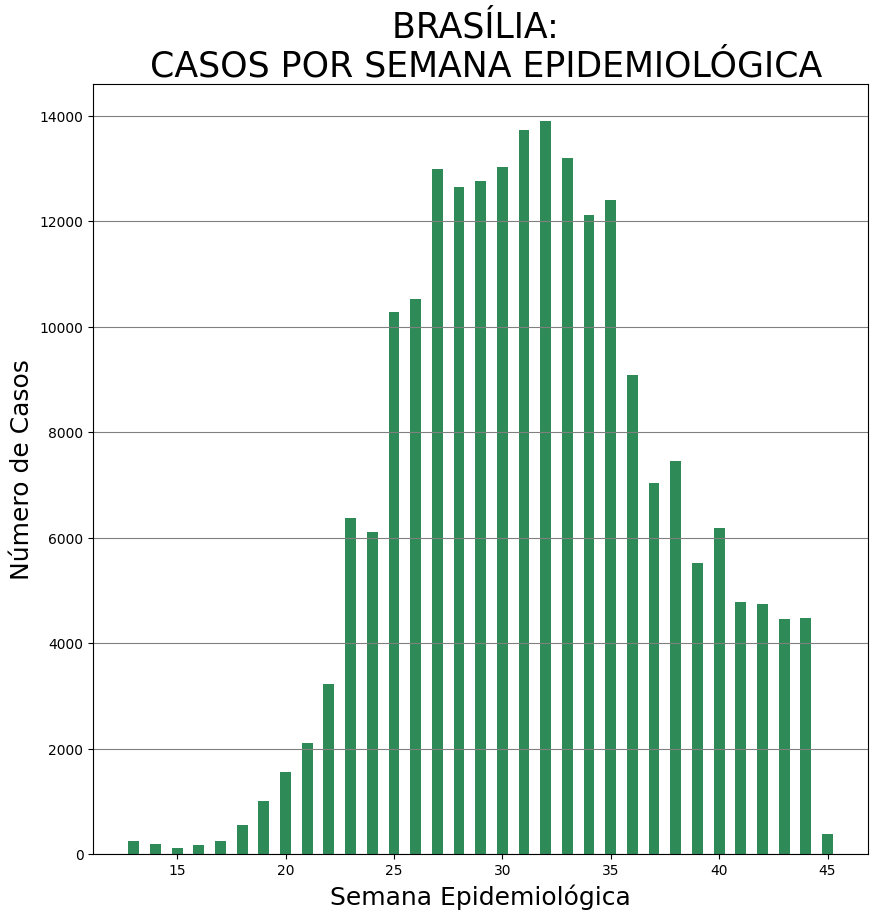

Casos por semana epidemiológica
     semanaEpi  casosNovos
0          13         260
1          14         194
2          15         125
3          16         183
4          17         251
5          18         553
6          19        1010
7          20        1564
8          21        2111
9          22        3223
10         23        6376
11         24        6109
12         25       10279
13         26       10528
14         27       12994
15         28       12646
16         29       12757
17         30       13024
18         31       13735
19         32       13902
20         33       13190
21         34       12113
22         35       12399
23         36        9079
24         37        7041
25         38        7450
26         39        5512
27         40        6175
28         41        4786
29         42        4735
30         43        4457
31         44        4484
32         45         391


In [19]:
casos_semana_local(df_cidade_sem, Muni)

### Função gráfico de óbitos por semana epidemiológica
* recebe:
    1. DataFrame do estado ou cidade agregado por semana epidemiológica
    1. String com o nome do local

In [20]:
def obitos_semana_local(df, local, pathfigs = './figs/'):     
    plt.figure(figsize=(10,10))
    plt.grid(axis='y', color='grey')
    plt.title('{}: \n Óbitos por Semana Epidemiológica'.format(local).upper(), fontsize=25)
    plt.xlabel('Semana Epidemiológica', fontsize=18)
    plt.ylabel('Número de Óbitos', fontsize=18)
    plt.bar('semanaEpi', 'obitosNovos', data=df, color= 'dimgray', width=.5)
    plt.savefig( pathfigs + local + '_semana_obitos_' + str(df['semanaEpi'].max()) + '.png', format ='png')


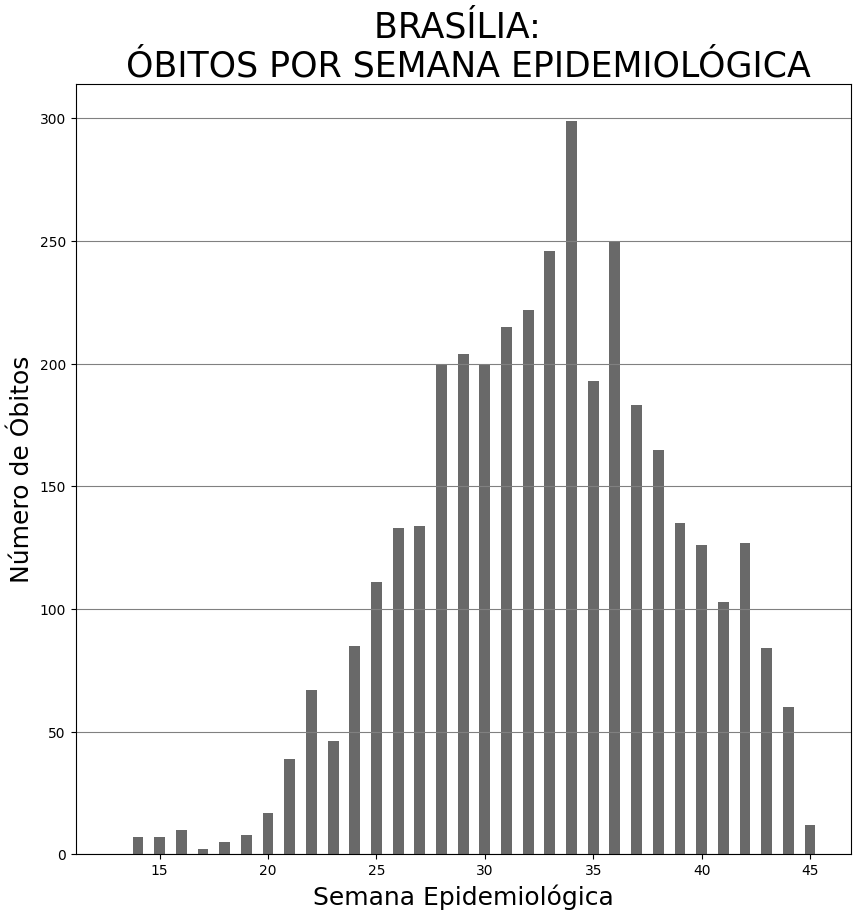

In [21]:
obitos_semana_local(df_cidade_sem, Muni)

### Baixando GeoJSon do estado

In [22]:
url = "https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/"
fname = uf.upper() + '.json'
path = os.path.abspath(os.getcwd())
print(path)
path = path + '\geojsonDL'
try:
    os.mkdir(path)
except FileExistsError:
    pass
filepath = path + '\\' + fname
get_file(filepath, url+fname )

d:\GitRepos\graficos_covid\acompanhamento_df


'd:\\GitRepos\\graficos_covid\\acompanhamento_df\\geojsonDL\\DF.json'

### Carregando arquivo GeoJson do estado

In [23]:
mapa = gpd.read_file(filepath, driver='GeoJSON')

### Função gráfico: mapa de casos nos municípios por mil habitantes

In [24]:
def mapa_casos_estado(df, df_geo, uf, muni, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    casos_p_habitante = mapaPlot['casosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(casos_p_habitante, k=nLevels)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    geoplot.polyplot(df_geo, ax=ax1)

    plt.title('Covid-19 -- {} \nCasos Diagnosticados em cada município por mil habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=casos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Oranges', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_casos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    

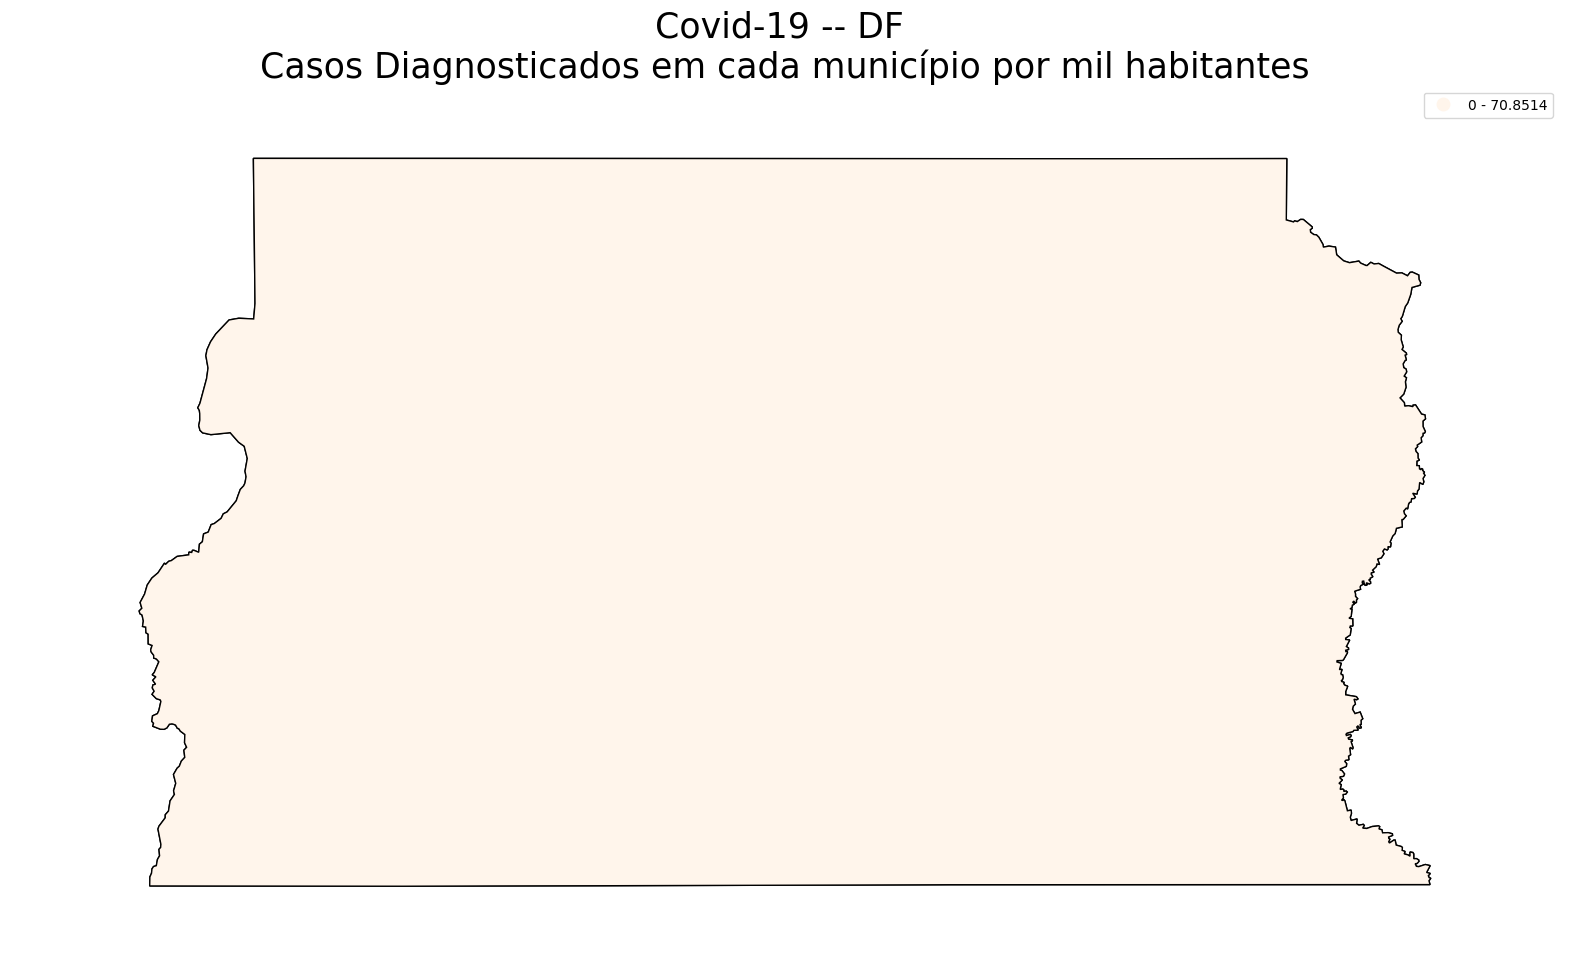

In [25]:
mapa_casos_estado(df_est, mapa, uf, Muni, 20)

### Função gráfico: mapa de óbitos nos municípios por mil habitantes

In [26]:
def mapa_obitos_estado(df, df_geo, uf, nLevels, pathfigs = './figs/'):
    muniMapa = df.groupby('municipio')
    muniMapa = muniMapa.agg({'casosNovos': sum, 'obitosNovos': sum, 'populacaoTCU2019': 'max'})
    mapaPlot = df_geo.join(muniMapa, on='NOME', how= 'left')

    mapaPlot.dropna(inplace=True)

    obitos_p_habitante = mapaPlot['obitosNovos']*10**3 / mapaPlot['populacaoTCU2019']
    scheme = mapclassify.Quantiles(obitos_p_habitante, k=nLevels)

    fig, ax1 = plt.subplots(1, 1, figsize=(20,15))

    
    
    geoplot.polyplot(df_geo, ax=ax1)
    

    plt.title('Covid-19 -- {} \nÓbitos Registrados em Cada Município por Mil Habitantes'.format(uf.upper()), fontsize=25 )
    geoplot.choropleth(
        mapaPlot, hue=obitos_p_habitante, scheme=scheme, ax=ax1,
        cmap='Reds', legend=True
    )
    plt.savefig( pathfigs + uf.upper() + '_mapa_obitos_' + str(df['data'].max()).replace(":", "_") + '.png', format ='png')
    


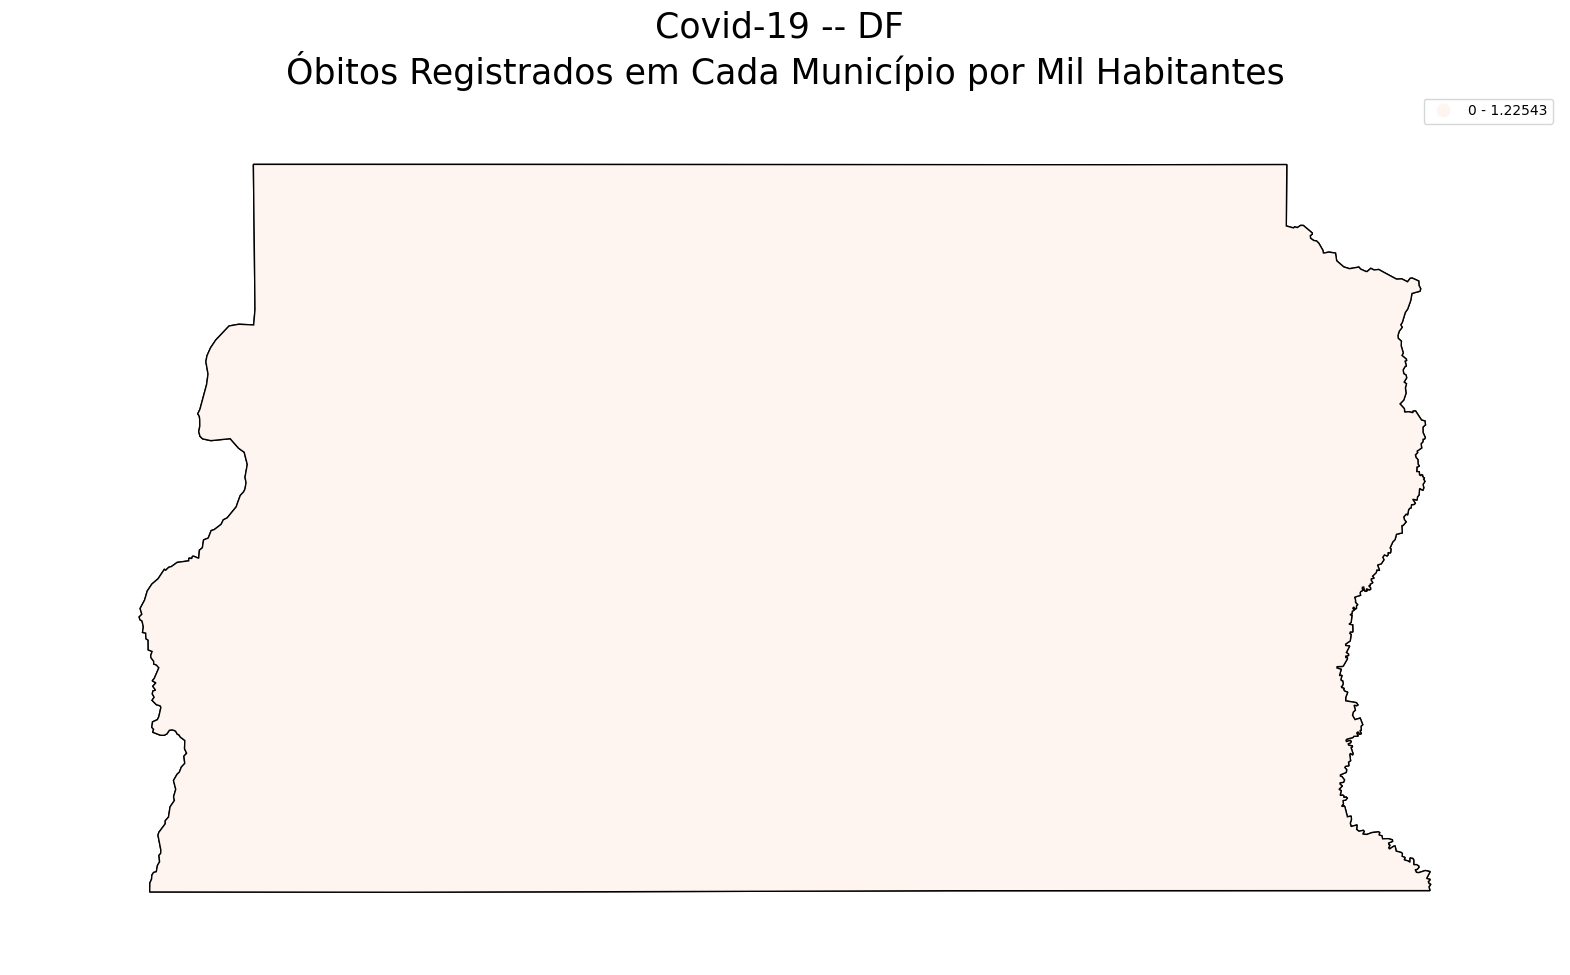

In [27]:
mapa_obitos_estado(df_est, mapa, uf, 20)